# MRO - Modelo de Recomendação de Ofertas
## Modelagem



## Bibliotecas

In [92]:
#Avisos
import warnings

# Manipulação de dados
import pandas as pd
import numpy as np
import os
import pickle

# Datas
from datetime import datetime
import calendar

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
from scipy.stats import f_oneway

# Pré-processamento
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)

# Modelagem
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Avaliação de modelos
from sklearn.metrics import (
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score
)

# Validação cruzada e otimização
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)

# Agrupamento
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline

# Salvamento de modelos
import joblib


## Funções

In [90]:
# Função para preencher valores ausentes por média de grupo
def preencher_media_grupo(df, col, grupo):
    media = df.groupby(grupo)[col].transform('mean')
    return df[col].fillna(media)

# Função para treinar o KMeans, salvar artefatos e gerar resumo comportamental por cluster
def treinar_kmeans(produto, X_train):
    print(f'\nTreinando modelo para: {produto}')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Método do cotovelo
    inertia = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.plot(range(2, 10), inertia, 'bx-')
    plt.title(f'Método do cotovelo - {produto}')
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inércia")
    plt.show()

    diff = np.diff(inertia)
    diff2 = np.diff(diff)
    best_k = np.argmin(diff2) + 2
    
    print(f'Melhor k Real: {best_k}')
    
    # Forçando k = 3
    best_k = 3
    
    print(f'Melhor k: {best_k}')

    # Treinar modelo final
    modelo_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    modelo_final.fit(X_scaled)
    X_train_clusterizado = X_train.copy()
    X_train_clusterizado['cluster'] = modelo_final.labels_

    # Pastas relativas
    pasta_modelos = os.path.join('ifood', 'models')
    pasta_results = os.path.join(pasta_modelos, 'results')

    os.makedirs(pasta_modelos, exist_ok=True)
    os.makedirs(pasta_results, exist_ok=True)

    # Salvar modelo e scaler em pasta_modelos
    with open(os.path.join(pasta_modelos, f'{produto}_kmeans.pkl'), 'wb') as f:
        pickle.dump(modelo_final, f)
    with open(os.path.join(pasta_modelos, f'{produto}_scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)

    # Salvar centróides no root do projeto (ou pode salvar na pasta_results se quiser)
    centroides = modelo_final.cluster_centers_
    pd.DataFrame(centroides, columns=X_train.columns).to_csv(f'{produto}_centroides.csv', index=False)

    # Calcular e salvar raio máximo por cluster na pasta modelos
    distancias = np.linalg.norm(X_scaled - modelo_final.cluster_centers_[modelo_final.labels_], axis=1)
    raio_max = pd.Series(distancias).groupby(X_train_clusterizado['cluster']).max()
    raio_max.to_csv(os.path.join(pasta_modelos, f'{produto}_raio_max.csv'))

    # Salvar resumo comportamental na pasta_results
    resumo = X_train_clusterizado.groupby('cluster').mean().round(2)
    contagem = X_train_clusterizado['cluster'].value_counts(normalize=True).sort_index() * 100
    resumo['perc_base'] = contagem.round(2)
    resumo.to_csv(os.path.join(pasta_results, f'{produto}_resumo_cluster.csv'))

    print("Resumo comportamental dos clusters salvo como CSV.")
    print("Modelo, centróides, raios e resumo salvos com sucesso.")
    
    return modelo_final, scaler, centroides, raio_max, resumo

# Função para mostrar a importância das variáveis para o melhor modelo
def mostrar_importancia_variaveis(modelo, X):
    if hasattr(modelo.named_steps['clf'], 'feature_importances_'):
        importancias = modelo.named_steps['clf'].feature_importances_
    elif hasattr(modelo.named_steps['clf'], 'coef_'):
        # Para LogisticRegression (multiclasse): pegar a média absoluta dos coeficientes por feature
        importancias = np.mean(np.abs(modelo.named_steps['clf'].coef_), axis=0)
    else:
        print("Modelo não suporta feature_importances_ ou coef_")
        return
    
    # Criar dataframe para exibir importâncias
    df_importancias = pd.DataFrame({
        'feature': X.columns,
        'importance': importancias
    }).sort_values(by='importance', ascending=False)
    
    print(df_importancias)
    
    # Plotar as importâncias
    plt.figure(figsize=(10,6))
    plt.barh(df_importancias['feature'], df_importancias['importance'])
    plt.gca().invert_yaxis()
    plt.title("Importância das Variáveis")
    plt.show()


# --- Função de aprendizado supervisionado ajustada para multi-classes (offer_id) ---
def aprendizado_supervisionado(X_train, X_test, y_train, y_test, df_metricas_por_grupo, X_test_geral, nome_modelo_salvar):
    
    modelos = {
        'LogisticRegression': (
            LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'),
            {'clf__C': [0.1, 1, 10]}
        ),
        'DecisionTree': (
            DecisionTreeClassifier(random_state=42),
            {'clf__max_depth': [None, 5, 10, 20], 'clf__min_samples_split': [2, 5, 10]}
        ),
        'RandomForest': (
            RandomForestClassifier(random_state=42),
            {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 5, 10]}
        ),
        'XGBClassifier': (
            XGBClassifier(eval_metric='mlogloss', tree_method='hist', random_state=42),
            {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 6], 'clf__learning_rate': [0.05, 0.1]}
        )
    }

    melhores_modelos = {}
    lista_metricas_por_grupo = []
    
    # DataFrame para salvar probabilidades (probabilidades para cada classe)
    df_probabilidades = pd.DataFrame()
    if 'num_telefone' in X_test_geral.columns:
        df_probabilidades['num_telefone'] = X_test_geral['num_telefone']
    df_probabilidades['true_offer_id'] = y_test.reset_index(drop=True)

    for nome, (modelo, parametros) in modelos.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', modelo)
        ])

        grid = GridSearchCV(pipeline, param_grid=parametros, scoring='f1_weighted', cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)

        melhores_modelos[nome] = grid.best_estimator_

        # Prever classes e probabilidades
        y_pred = grid.predict(X_test)
        y_pred_proba = grid.predict_proba(X_test)

        # Relatório por classe
        relatorio = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        df_relatorio = pd.DataFrame(relatorio).transpose()
        
        print(f'Relatório de métricas por classe para {nome}:')
        print(df_relatorio)


        # Adicionar colunas de probabilidade para cada classe no df_probabilidades
        for idx, classe in enumerate(grid.classes_):
            col_name = f'proba_{nome}_{classe}'
            df_probabilidades[col_name] = y_pred_proba[:, idx]

        # Métricas multi-classe
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f'ALGORITMO: {nome} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}')

        lista_metricas_por_grupo.append({
            'metodo': f'SUP. MULTI ({nome})',
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1': round(f1, 4)
        })


    # Salvar probabilidades
    pasta_probabilidades = os.path.join('ifood', 'models', 'results')
    os.makedirs(pasta_probabilidades, exist_ok=True)
    nome_arquivo_prob = f'probabilidades_por_{nome_modelo_salvar}.csv' if nome_modelo_salvar else 'probabilidades_por_algoritmo_multiclasse.csv'
    caminho_prob = os.path.join(pasta_probabilidades, nome_arquivo_prob)
    df_probabilidades.to_csv(caminho_prob, index=False, sep=';')
    print(f"💾 Probabilidades salvas em: {caminho_prob}")

    # Salvar o melhor modelo baseado na F1 score
    melhor_modelo = max(lista_metricas_por_grupo, key=lambda x: x['f1'])
    nome_melhor = melhor_modelo['metodo'].split('(')[-1].replace(')', '')

    modelo_para_salvar = melhores_modelos[nome_melhor]

    pasta_modelos = os.path.join('ifood', 'models')
    os.makedirs(pasta_modelos, exist_ok=True)
    nome_arquivo_modelo = f'{nome_modelo_salvar}.pkl' if nome_modelo_salvar else 'melhor_modelo_f1_multiclasse.pkl'
    caminho_modelo = os.path.join(pasta_modelos, nome_arquivo_modelo)

    joblib.dump(modelo_para_salvar, caminho_modelo)

    print(f"\n✅ Melhor modelo salvo: {nome_melhor} com F1-score {melhor_modelo['f1']:.4f}")
    print(f"💾 Modelo salvo em: {caminho_modelo}")

    
    # Salvar probabilidades
    #df_probabilidades.to_csv('probabilidades_por_algoritmo_multiclasse.csv', index=False, sep=';')
    #print(f"💾 Probabilidades salvas em: bases/probabilidades_por_algoritmo_multiclasse.csv")

    # Salvar o melhor modelo baseado na F1 score
    #melhor_modelo = max(lista_metricas_por_grupo, key=lambda x: x['f1'])
    #nome_melhor = melhor_modelo['metodo'].split('(')[-1].replace(')', '')
    #modelo_para_salvar = melhores_modelos[nome_melhor]
    #joblib.dump(modelo_para_salvar, 'melhor_modelo_f1_multiclasse.pkl')

    # Concatenar métricas ao df original
    #df_novos = pd.DataFrame(lista_metricas_por_grupo)
    #df_metricas_por_grupo = pd.concat([df_metricas_por_grupo, df_novos], ignore_index=True)
        
    #print(f"\n✅ Melhor modelo salvo: {nome_melhor} com F1-score {melhor_modelo['f1']:.4f}")


    # Depois de selecionar o melhor modelo, chame:
    mostrar_importancia_variaveis(modelo_para_salvar, X_train_clean)
    
    return df_metricas_por_grupo

## Carga dos Dados Processados

In [15]:
# --- 1. Definindo caminho base para os arquivos JSON ---
caminho = os.path.join('..', 'data', 'processed')

# --- 2. Carga de arquivos JSON em DataFrames ---
base_final_filtrada = pd.read_json(os.path.join(caminho, 'data_processed.json'), lines=True)
transactions_v2 = pd.read_json(os.path.join(caminho, 'transactions_v2.json'), lines=True)
ofertas_recebidas = pd.read_json(os.path.join(caminho, 'ofertas_recebidas.json'), lines=True)

base_final_filtrada.head(3)

,account_id,time_since_test_start,amount,offer_id,oferta_utilizada,age,registered_on,gender,credit_card_limit,data_ajustada,tempo_de_casa
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83,ae264e3637204a6fb9bb56bc8210ddfd,False,20,20160711,F,30000.0,1473552000000,108
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56,2906b810c7d4411798c6938adc9daaa5,True,42,20160117,M,96000.0,1474070400000,108
2,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51,5a8bc65990b245e5a138643cd4eb9837,False,55,20171016,F,94000.0,1505520000000,96


## Análise Exploratória de Dados

In [6]:
# Colunas categóricas (exemplo)
categorical_cols = ['oferta_utilizada', 'gender']

for col in categorical_cols:
    print(f"Coluna: {col}")
    print(base_final_filtrada[col].value_counts(dropna=False))
    print('-'*40)

Coluna: oferta_utilizada
oferta_utilizada
False    130578
True      66178
Name: count, dtype: int64
----------------------------------------
Coluna: gender
gender
M       103054
F        72847
None     18330
O         2525
Name: count, dtype: int64
----------------------------------------


In [7]:
print('PRECISÃO ATUAL:', len(base_final_filtrada[base_final_filtrada['oferta_utilizada']==True])/len(base_final_filtrada))

PRECISÃO ATUAL: 0.33634552440586307


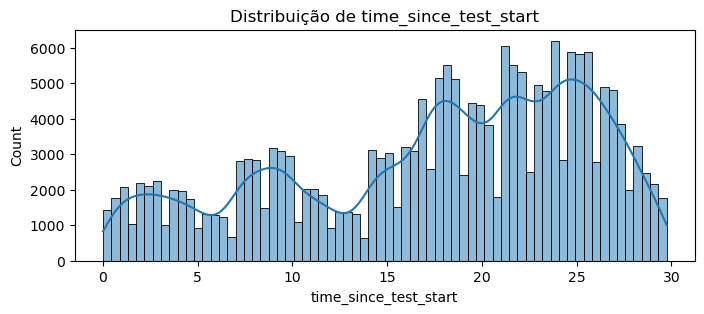

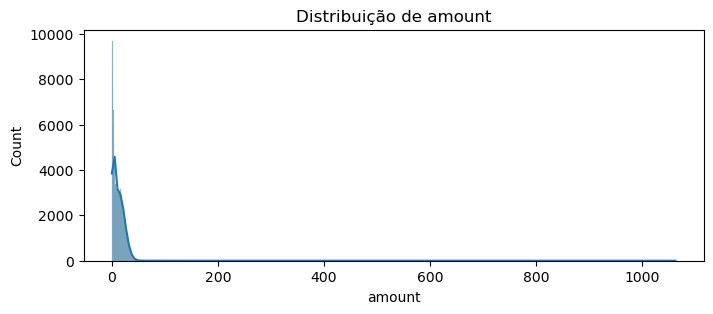

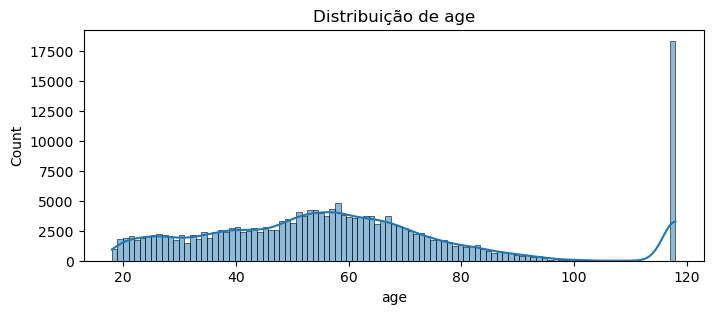

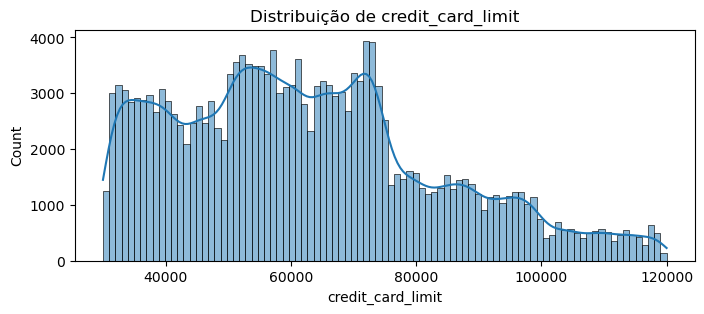

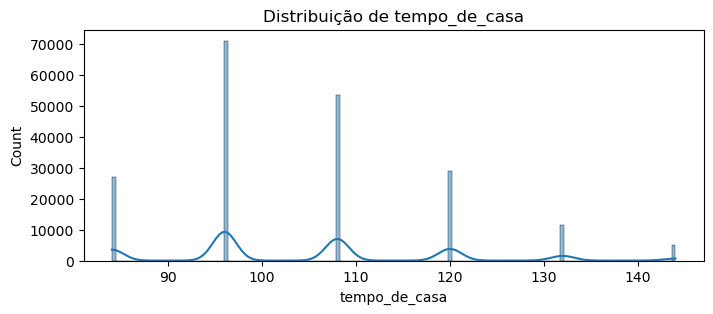

In [10]:
# Ignorar o aviso chato do Pandas
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na*")

numerical_cols = ['time_since_test_start', 'amount', 'age', 'credit_card_limit', 'tempo_de_casa']

for col in numerical_cols:
    plt.figure(figsize=(8, 3))
    
    # Substitui infinitos por NaN e remove os NaN
    dados = base_final_filtrada[col].replace([np.inf, -np.inf], np.nan).dropna()
    
    sns.histplot(dados, kde=True)
    plt.title(f'Distribuição de {col}')
    plt.show()

## Engenharia de Features

In [16]:
# --- 17. Criando novas variáveis a partir da média da transação e desconto.

# Primeiro, garantir que 'offer_start' está no dataframe de ofertas_recebidas
# Já tem em seu código: ofertas_recebidas['offer_start']
# 1. Expandir ofertas_recebidas para repetir para cada transação do cliente
transacoes_expand = transactions_v2[['account_id', 'time_since_test_start', 'amount', 'reward']].copy()

# 2. Fazer merge para juntar transações com ofertas por account_id
merged = transacoes_expand.merge(
    ofertas_recebidas[['account_id', 'offer_id', 'offer_start']],
    on='account_id',
    how='inner'
)

# 3. Filtrar transações que aconteceram antes (ou no dia) da oferta
mask = merged['time_since_test_start'] <= merged['offer_start']
merged_filtrado = merged[mask]

# 4. Calcular média por account_id e offer_id
medias = merged_filtrado.groupby(['account_id', 'offer_id'])[['amount', 'reward']].mean().reset_index()

# 5. Renomear colunas para não confundir
medias.rename(columns={
    'amount': 'mean_amount_ate_oferta',
    'reward': 'mean_reward_ate_oferta'
}, inplace=True)

# 6. Juntar as médias no dataframe original de ofertas_recebidas
ofertas_recebidas = ofertas_recebidas.merge(
    medias,
    on=['account_id', 'offer_id'],
    how='left'
)

# 7. Agora junte essa informação ao base_final_filtrada conforme você já fazia
base_final_com_media = base_final_filtrada.merge(
    ofertas_recebidas[['account_id', 'offer_id', 'mean_amount_ate_oferta', 'mean_reward_ate_oferta']],
    on=['account_id', 'offer_id'],
    how='left'
)

# --- 18. Aplica a média em variáveis númericas que possuem nan.

# Selecionar as colunas numéricas
numericas = base_final_com_media.select_dtypes(include=['number']).columns

#Limitar a idade, 118 é bem estranho.
#base_final_com_media['age'] = base_final_com_media['age'].clip(upper=100)

# Preencher os NaNs com a média de cada coluna
for col in numericas:
    media_col = base_final_com_media[col].mean()
    base_final_com_media[col].fillna(media_col, inplace=True)


# --- 19. Criando novas variáveis 

# Usar o DataFrame que contém as médias por cliente
df = base_final_com_media.copy()

df['gender'] = df['gender'].fillna('O')

# Substituir zeros por NaN para evitar divisão por zero
df['tempo_de_casa'] = df['tempo_de_casa'].replace(0, np.nan)
df['mean_amount_ate_oferta'] = df['mean_amount_ate_oferta'].replace(0, np.nan)
df['mean_reward_ate_oferta'] = df['mean_reward_ate_oferta'].replace(0, np.nan)

# 1. 'tempo_desde_registro':  
#    Diferença entre o tempo da transação (em dias desde o início do teste) 
#    e o tempo que o cliente está registrado na base (em dias).  
#    Indica quanto tempo se passou desde o registro do cliente até a transação.
df['tempo_desde_registro'] = df['time_since_test_start'] - df['tempo_de_casa'] * 30

# 2. 'amount_por_tempo_de_casa':  
#    Gasto médio mensal do cliente. Calculado dividindo o gasto médio por transação ('mean_amount') 
#    pelo tempo de casa (em meses).  
#    Indica o quanto o cliente costuma gastar por mês, em média.
df['amount_por_tempo_de_casa'] = df['mean_amount_ate_oferta'] / df['tempo_de_casa']

# 3. 'reward_por_amount':  
#    Eficiência da oferta para o cliente. Calculado pela média de recompensas ('mean_reward') 
#    dividida pela média de gastos ('mean_amount').  
#    Indica quanto de recompensa o cliente gera proporcionalmente ao valor gasto.
df['reward_por_amount'] = df['mean_reward_ate_oferta'] / df['mean_amount_ate_oferta']

# 5. 'faixa_etaria':  
#    Faixa etária categorizada do cliente, para segmentação mais clara.  
#    Categoriza a idade em intervalos predefinidos.
# Calcular os quartis (incluindo mínimo e máximo)
quartis = df['age'].quantile([0, 0.25, 0.5, 0.75, 1]).values

# Criar labels dinâmicas com base nos valores dos quartis
labels = [f'{int(quartis[i])}-{int(quartis[i+1]-1)}' for i in range(len(quartis)-1)]

# Criar a faixa etária usando os quartis e os labels gerados
df['faixa_etaria'] = pd.cut(df['age'], bins=quartis, labels=labels, include_lowest=True)


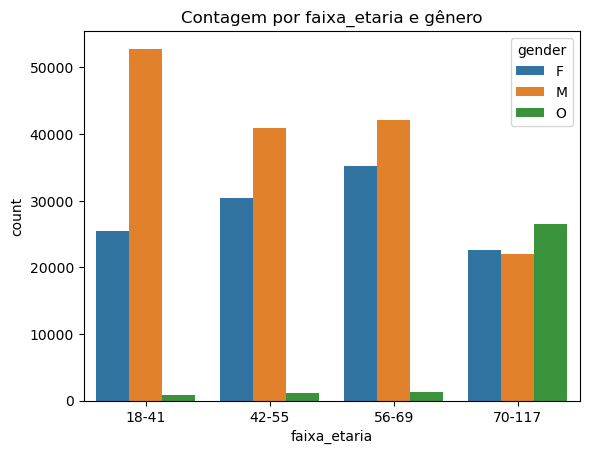

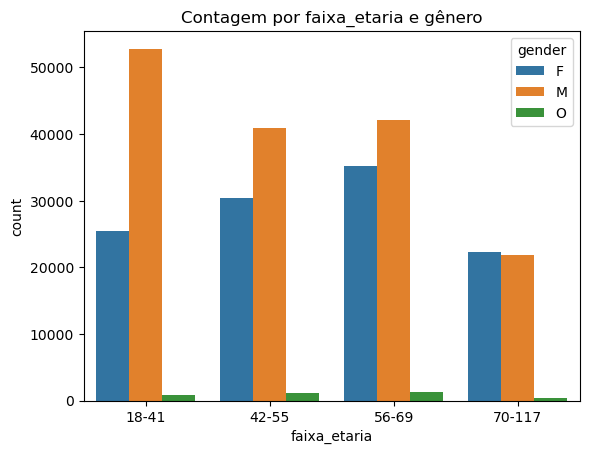

In [19]:
warnings.filterwarnings("ignore", category=FutureWarning, message=".*observed=False*")

sns.countplot(data=df, x='faixa_etaria', hue='gender')
plt.title('Contagem por faixa_etaria e gênero')
plt.show()

sns.countplot(data=df[df['age']<100], x='faixa_etaria', hue='gender')
plt.title('Contagem por faixa_etaria e gênero')
plt.show()

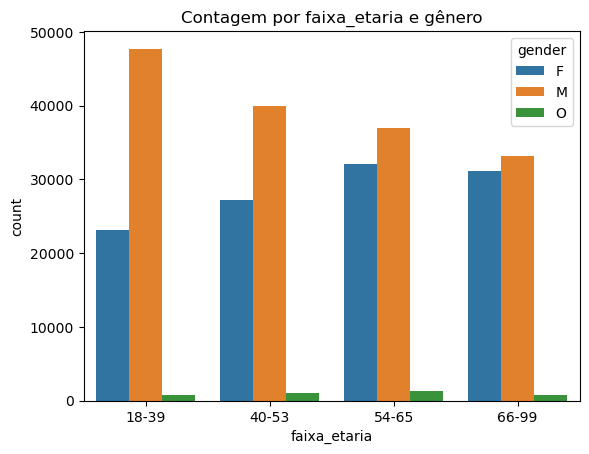

In [20]:
#Dois comportamentos estranho genero O muito concetrado acima de 117. Além disso, muito fora da curva ter muitos clientes com mais de 117 anos. Diante disso, esses dados serão excluídos.
df = df[df['age'] <= 100]

#recalcula as faixas:

# Calcular os quartis (incluindo mínimo e máximo)
quartis = df['age'].quantile([0, 0.25, 0.5, 0.75, 1]).values

# Criar labels dinâmicas com base nos valores dos quartis
labels = [f'{int(quartis[i])}-{int(quartis[i+1]-1)}' for i in range(len(quartis)-1)]

# Criar a faixa etária usando os quartis e os labels gerados
df['faixa_etaria'] = pd.cut(df['age'], bins=quartis, labels=labels, include_lowest=True)

sns.countplot(data=df, x='faixa_etaria', hue='gender')
plt.title('Contagem por faixa_etaria e gênero')
plt.show()

## Correlação de Variáveis

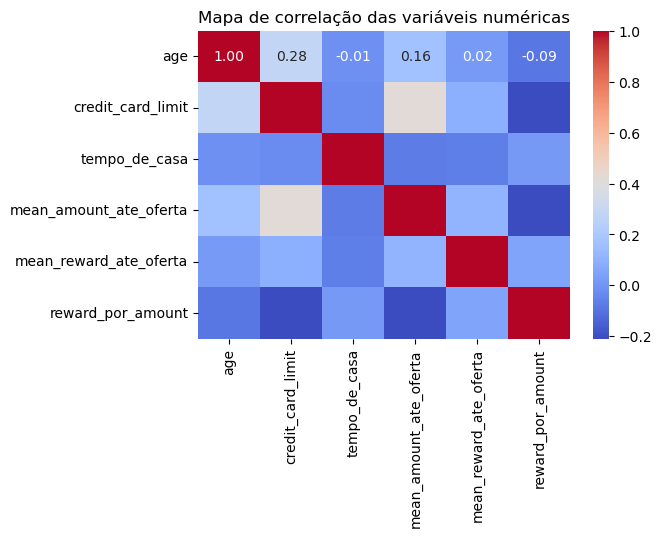

In [32]:
variaveis_numericas = df.select_dtypes(include='number').columns

# Remover 'amount' e 'time_since_test_start' da lista, variaveis após refletem diretamente o evento
variaveis_numericas = [col for col in variaveis_numericas if col not in ['amount', 'time_since_test_start', 'tempo_desde_registro', 'amount_por_tempo_de_casa', 'data_ajustada', 'registered_on']]

# Correlação Bi-variada
plt.figure(figsize=(6, 4))
sns.heatmap(df[variaveis_numericas].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de correlação das variáveis numéricas')
plt.show()


In [33]:
# Calcular matriz de correlação
corr = df[variaveis_numericas].corr()

# Mostrar a matriz com valores numéricos
print(corr.round(2))

                         age  credit_card_limit  tempo_de_casa  \
age                     1.00               0.28          -0.01   
credit_card_limit       0.28               1.00          -0.03   
tempo_de_casa          -0.01              -0.03           1.00   
mean_amount_ate_oferta  0.16               0.42          -0.08   
mean_reward_ate_oferta  0.02               0.09          -0.07   
reward_por_amount      -0.09              -0.21           0.02   

                        mean_amount_ate_oferta  mean_reward_ate_oferta  \
age                                       0.16                    0.02   
credit_card_limit                         0.42                    0.09   
tempo_de_casa                            -0.08                   -0.07   
mean_amount_ate_oferta                    1.00                    0.11   
mean_reward_ate_oferta                    0.11                    1.00   
reward_por_amount                        -0.21                    0.05   

                  

In [34]:
#Correlação com variável resposta

# Calcular ANOVA para cada variável numérica vs offer_id
resultados_anova = {}
for var in variaveis_numericas:
    grupos = [grupo[var].dropna() for _, grupo in df.groupby('offer_id')]
    if all(len(grupo) > 1 for grupo in grupos):  # precisa de mais de 1 valor por grupo
        stat, p = f_oneway(*grupos)
        resultados_anova[var] = p

# Mostrar ordenado por p-valor (quanto menor, mais significativa a diferença entre grupos)
pd.Series(resultados_anova).sort_values()


mean_reward_ate_oferta     0.000000e+00
reward_por_amount         1.419158e-144
tempo_de_casa             1.888776e-123
credit_card_limit         1.861676e-115
mean_amount_ate_oferta     3.798545e-94
age                        1.012994e-41
dtype: float64

## Treinamento dos Resultados e Avaliação dos Resultados

## Modelo 1: Modelo de Recomendação de Oferta

Qtd offer_label treino: 10
Qtd offer_label teste: 10
Proporção oferta_utilizada original: 0.367
Proporção oferta_utilizada treino: 0.500
Proporção oferta_utilizada teste: 0.366
Tamanho treino: 161322
Tamanho teste: 55021
Overlap entre treino e teste: 0
(161322, 8) (161322,)
(55021, 8) (55021,)
Tamanho treino: 161322
Tamanho teste: 55021
Relatório de métricas por classe para LogisticRegression:
                                  precision    recall  f1-score       support
0b1e1539f2cc45b7b9fa7c272da2e1d7   0.092929  0.015217  0.026151   6046.000000
2298d6c36e964ae4a3e7e9706d1fb8c2   0.000000  0.000000  0.000000   7740.000000
2906b810c7d4411798c6938adc9daaa5   0.120000  0.000587  0.001168   5110.000000
3f207df678b143eea3cee63160fa8bed   0.000000  0.000000  0.000000   2085.000000
4d5c57ea9a6940dd891ad53e9dbe8da0   0.257143  0.001893  0.003759   4754.000000
5a8bc65990b245e5a138643cd4eb9837   0.000000  0.000000  0.000000   2079.000000
9b98b8c7a33c4b65b9aebfe6a799e6d9   0.083333  0.000192  0.

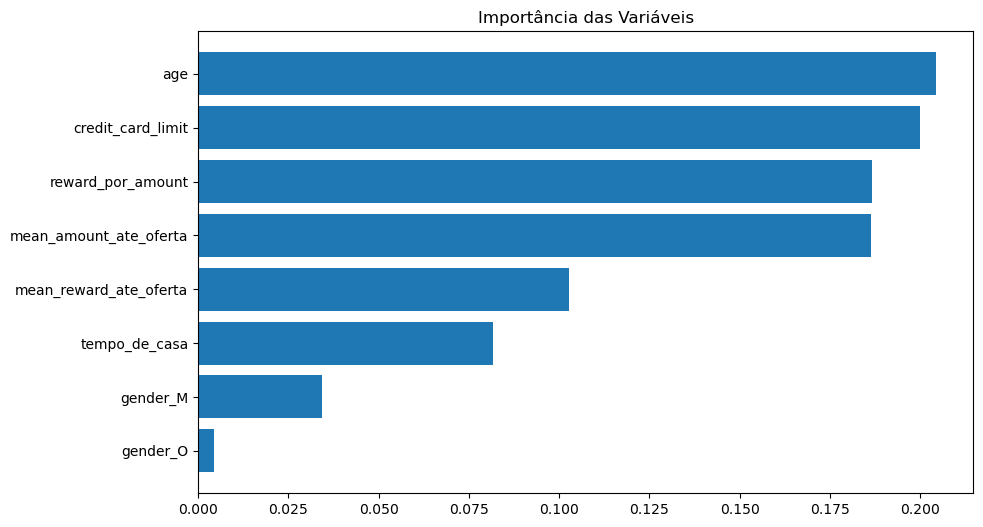

In [89]:
# Criar coluna combinada para target: offer_id + oferta_utilizada
df['offer_label'] = df['offer_id'].astype(str)

# LabelEncoder no target combinado
le = LabelEncoder()
df['offer_label_encoded'] = le.fit_transform(df['offer_label'])

# Proporção original de True (para dividir treino/teste mantendo proporção de oferta utilizada)
prop_true = df['oferta_utilizada'].mean()

# Decide tamanho do teste, por exemplo 20% da base
tamanho_teste = int(len(df) * 0.2)
tamanho_teste_true = int(tamanho_teste * prop_true)
tamanho_teste_false = tamanho_teste - tamanho_teste_true

# Seleciona amostra do teste com proporção original
true_indices = df[df['oferta_utilizada'] == True].index
false_indices = df[df['oferta_utilizada'] == False].index

teste_true_idx = true_indices.to_series().sample(n=tamanho_teste_true, random_state=42)
teste_false_idx = false_indices.to_series().sample(n=tamanho_teste_false, random_state=42)

teste_idx = pd.concat([teste_true_idx, teste_false_idx])

# DataFrame de teste
df_teste = df.loc[teste_idx]

# Treino: todos os outros dados que não estão no teste
df_treino = df.drop(teste_idx)

# Balancear treino para 50% True e 50% False (com subamostragem)
true_treino_idx = df_treino[df_treino['oferta_utilizada'] == True].index
false_treino_idx = df_treino[df_treino['oferta_utilizada'] == False].index

tamanho_treino_por_classe = min(len(true_treino_idx), len(false_treino_idx))

true_treino_idx_sampled = true_treino_idx.to_series().sample(n=tamanho_treino_por_classe, random_state=42)
false_treino_idx_sampled = false_treino_idx.to_series().sample(n=tamanho_treino_por_classe, random_state=42)

treino_idx = pd.concat([true_treino_idx_sampled, false_treino_idx_sampled])

df_treino_balanced = df.loc[treino_idx]

# Verificações
print(f"Qtd offer_label treino: {df_treino_balanced['offer_label'].nunique()}")
print(f"Qtd offer_label teste: {df_teste['offer_label'].nunique()}")
print(f"Proporção oferta_utilizada original: {prop_true:.3f}")
print(f"Proporção oferta_utilizada treino: {df_treino_balanced['oferta_utilizada'].mean():.3f}")
print(f"Proporção oferta_utilizada teste: {df_teste['oferta_utilizada'].mean():.3f}")
print(f"Tamanho treino: {len(df_treino_balanced)}")
print(f"Tamanho teste: {len(df_teste)}")
print(f"Overlap entre treino e teste: {len(set(df_treino_balanced.index).intersection(set(df_teste.index)))}")

# Aplica encoding nos dataframes de treino e teste na coluna combinada
df_treino_balanced['offer_label_encoded'] = le.transform(df_treino_balanced['offer_label'])
df_teste['offer_label_encoded'] = le.transform(df_teste['offer_label'])

# OneHotEncoder para gender (ajustar no df completo e transformar treino e teste)
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe.fit(df[['gender']])  # Ajusta no df completo para pegar todas categorias

# Transformar gender em treino
gender_train_encoded = ohe.transform(df_treino_balanced[['gender']])
gender_train_cols = ohe.get_feature_names_out(['gender'])
df_gender_train = pd.DataFrame(gender_train_encoded, columns=gender_train_cols, index=df_treino_balanced.index)

# Transformar gender em teste
gender_test_encoded = ohe.transform(df_teste[['gender']])
df_gender_test = pd.DataFrame(gender_test_encoded, columns=gender_train_cols, index=df_teste.index)

# Criar X e y de treino
X_train_clean = pd.concat([df_treino_balanced[variaveis_numericas], df_gender_train], axis=1)
y_train_clean = df_treino_balanced['offer_label_encoded']

# Criar X e y de teste
X_test_clean = pd.concat([df_teste[variaveis_numericas], df_gender_test], axis=1)
y_test_clean = df_teste['offer_label_encoded']

print(X_train_clean.shape, y_train_clean.shape)
print(X_test_clean.shape, y_test_clean.shape)

print(f'Tamanho treino: {X_train_clean.shape[0]}')
print(f'Tamanho teste: {X_test_clean.shape[0]}')

# Agora você pode chamar sua função de aprendizado com esses dados
df_metricas_por_grupo = pd.DataFrame()

df_metricas_por_grupo = aprendizado_supervisionado(
    X_train_clean,
    X_test_clean,
    y_train_clean,
    y_test_clean,
    df_metricas_por_grupo,
    X_test_clean, 'MRO')


# Modelo 2: Modelo de Propensão ao Uso da Oferta

(161322, 17) (161322,)
(55021, 17) (55021,)
Tamanho treino: 161322
Tamanho teste: 55021
Relatório de métricas por classe para LogisticRegression:
              precision    recall  f1-score       support
False          0.751509  0.375086  0.500411  34856.000000
True           0.421061  0.785619  0.548270  20165.000000
accuracy       0.525545  0.525545  0.525545      0.525545
macro avg      0.586285  0.580352  0.524341  55021.000000
weighted avg   0.630401  0.525545  0.517952  55021.000000
ALGORITMO: LogisticRegression | Precision: 0.6304 | Recall: 0.5255 | F1-Score: 0.5180
Relatório de métricas por classe para DecisionTree:
              precision    recall  f1-score       support
False          0.746086  0.620697  0.677640  34856.000000
True           0.491949  0.634862  0.554343  20165.000000
accuracy       0.625888  0.625888  0.625888      0.625888
macro avg      0.619018  0.627779  0.615991  55021.000000
weighted avg   0.652946  0.625888  0.632452  55021.000000
ALGORITMO: DecisionT

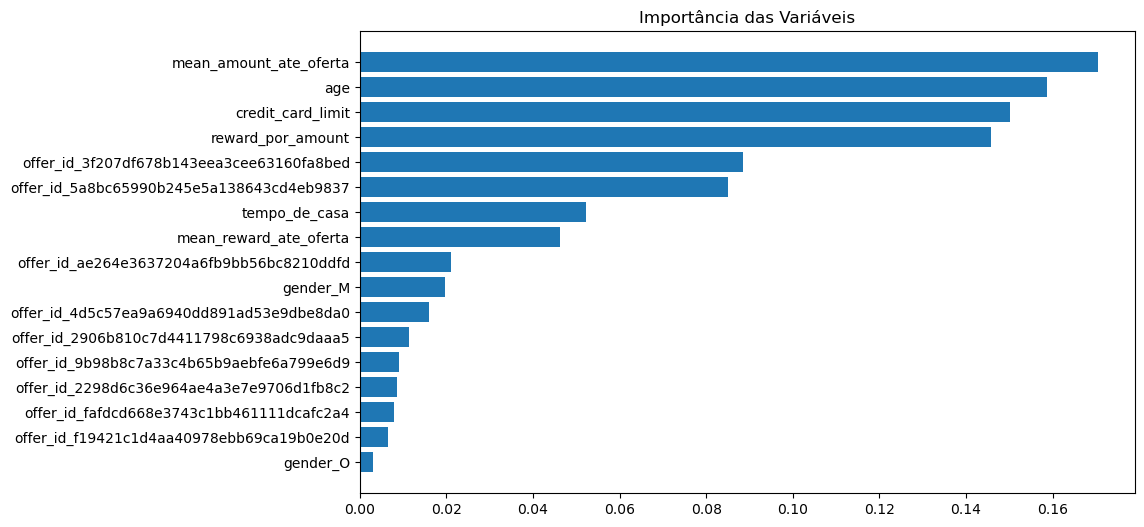

In [88]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np

# === 1. Coluna combinada para o target (caso ainda queira usar essa abordagem) ===
df['offer_label'] = df['oferta_utilizada'].astype(str)  # ou combine com offer_id se quiser

# === 2. LabelEncoder para a variável target combinada ===
le = LabelEncoder()
df['offer_label_encoded'] = le.fit_transform(df['offer_label'])

# === 3. Proporção original de True (para amostragem estratificada no teste) ===
prop_true = df['oferta_utilizada'].mean()
tamanho_teste = int(len(df) * 0.2)
tamanho_teste_true = int(tamanho_teste * prop_true)
tamanho_teste_false = tamanho_teste - tamanho_teste_true

# === 4. Separar índices True e False ===
true_indices = df[df['oferta_utilizada'] == True].index
false_indices = df[df['oferta_utilizada'] == False].index

# Amostragem estratificada
teste_true_idx = true_indices.to_series().sample(n=tamanho_teste_true, random_state=42)
teste_false_idx = false_indices.to_series().sample(n=tamanho_teste_false, random_state=42)

teste_idx = pd.concat([teste_true_idx, teste_false_idx])

# === 5. DataFrames de treino e teste ===
df_teste = df.loc[teste_idx]
df_treino = df.drop(teste_idx)

# === 6. Balancear o treino (50/50 entre True e False) ===
true_treino_idx = df_treino[df_treino['oferta_utilizada'] == True].index
false_treino_idx = df_treino[df_treino['oferta_utilizada'] == False].index
tamanho_treino_por_classe = min(len(true_treino_idx), len(false_treino_idx))

# Subamostragem
true_treino_idx_sampled = true_treino_idx.to_series().sample(n=tamanho_treino_por_classe, random_state=42)
false_treino_idx_sampled = false_treino_idx.to_series().sample(n=tamanho_treino_por_classe, random_state=42)
treino_idx = pd.concat([true_treino_idx_sampled, false_treino_idx_sampled])
df_treino_balanced = df.loc[treino_idx]

# === 7. OneHotEncoding para 'gender' ===
ohe_gender = OneHotEncoder(drop='first', sparse_output=False)
ohe_gender.fit(df[['gender']])

# Gênero no treino
gender_train_encoded = ohe_gender.transform(df_treino_balanced[['gender']])
gender_train_cols = ohe_gender.get_feature_names_out(['gender'])
df_gender_train = pd.DataFrame(gender_train_encoded, columns=gender_train_cols, index=df_treino_balanced.index)

# Gênero no teste
gender_test_encoded = ohe_gender.transform(df_teste[['gender']])
df_gender_test = pd.DataFrame(gender_test_encoded, columns=gender_train_cols, index=df_teste.index)

# === 8. OneHotEncoding para 'offer_id' como feature ===
ohe_offer = OneHotEncoder(drop='first', sparse_output=False)
ohe_offer.fit(df[['offer_id']])

# Offer_id no treino
offer_train_encoded = ohe_offer.transform(df_treino_balanced[['offer_id']])
offer_train_cols = ohe_offer.get_feature_names_out(['offer_id'])
df_offer_train = pd.DataFrame(offer_train_encoded, columns=offer_train_cols, index=df_treino_balanced.index)

# Offer_id no teste
offer_test_encoded = ohe_offer.transform(df_teste[['offer_id']])
df_offer_test = pd.DataFrame(offer_test_encoded, columns=offer_train_cols, index=df_teste.index)

# === 9. Variáveis numéricas ===
# Supondo que você já tenha uma lista pronta
# Exemplo: variaveis_numericas = ['income', 'age', 'transaction_count']
# (Ajuste conforme seu dataset)
X_train_clean = pd.concat([
    df_treino_balanced[variaveis_numericas],
    df_gender_train,
    df_offer_train
], axis=1)

X_test_clean = pd.concat([
    df_teste[variaveis_numericas],
    df_gender_test,
    df_offer_test
], axis=1)

# === 10. Target ===
# Aqui você pode usar:
# - y = df['oferta_utilizada']            --> para propensão de uso (binário)
# - y = df['offer_label_encoded']         --> se usou codificação combinada

y_train_clean = df_treino_balanced['oferta_utilizada']
y_test_clean = df_teste['oferta_utilizada']

# === 11. Verificações ===
print(X_train_clean.shape, y_train_clean.shape)
print(X_test_clean.shape, y_test_clean.shape)
print(f'Tamanho treino: {X_train_clean.shape[0]}')
print(f'Tamanho teste: {X_test_clean.shape[0]}')

# === 12. Chamada do modelo ===
# df_metricas_por_grupo deve existir fora ou ser criado agora
df_metricas_por_grupo = pd.DataFrame()

df_metricas_por_grupo = aprendizado_supervisionado(
    X_train_clean,
    X_test_clean,
    y_train_clean,
    y_test_clean,
    df_metricas_por_grupo,
    X_test_clean, 'MPUO'
)



Treinando modelo para: ifood_oferta


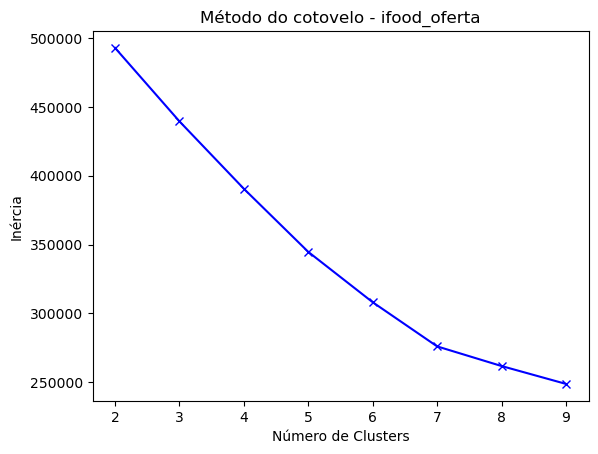

Melhor k Real: 7
Melhor k: 3
Resumo comportamental dos clusters salvo como CSV.
Modelo, centróides, raios e resumo salvos com sucesso.


In [93]:
X_cluster = df[df['oferta_utilizada']==True]
X_cluster = X_cluster.reset_index(drop=True)

modelo, scaler, centroides, raio_max, resumo = treinar_kmeans(
    produto='ifood_oferta',
    X_train=X_cluster[variaveis_numericas]
)

In [95]:
X_cluster

,account_id,time_since_test_start,amount,offer_id,oferta_utilizada,age,registered_on,gender,credit_card_limit,data_ajustada,...,mean_amount_ate_oferta,mean_reward_ate_oferta,tempo_desde_registro,amount_por_tempo_de_casa,reward_por_amount,faixa_etaria,offer_id_encoded,stratify_col,offer_label,offer_label_encoded
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56,2906b810c7d4411798c6938adc9daaa5,True,42,20160117,M,96000.0,1474070400000,...,34.560000,2.000000,-3240.00,0.320000,0.057870,40-53,2,2906b810c7d4411798c6938adc9daaa5_True,2906b810c7d4411798c6938adc9daaa5,2
1,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97,fafdcd668e3743c1bb461111dcafc2a4,True,39,20171217,F,67000.0,1505606400000,...,18.970000,2.000000,-2880.00,0.197604,0.105430,18-39,9,fafdcd668e3743c1bb461111dcafc2a4_True,fafdcd668e3743c1bb461111dcafc2a4,9
2,629fc02d56414d91bca360decdfa9288,0.00,33.90,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,52,20180605,M,72000.0,1536105600000,...,33.900000,5.000000,-2520.00,0.403571,0.147493,40-53,6,9b98b8c7a33c4b65b9aebfe6a799e6d9_True,9b98b8c7a33c4b65b9aebfe6a799e6d9,6
3,676506bad68e4161b9bbaffeb039626b,0.00,18.01,ae264e3637204a6fb9bb56bc8210ddfd,True,37,20170515,M,92000.0,1505433600000,...,18.010000,10.000000,-2880.00,0.187604,0.555247,18-39,7,ae264e3637204a6fb9bb56bc8210ddfd_True,ae264e3637204a6fb9bb56bc8210ddfd,7
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11,4d5c57ea9a6940dd891ad53e9dbe8da0,True,48,20150903,M,62000.0,1441238400000,...,19.110000,10.000000,-3600.00,0.159250,0.523286,40-53,4,4d5c57ea9a6940dd891ad53e9dbe8da0_True,4d5c57ea9a6940dd891ad53e9dbe8da0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100821,f3e801caeafe4899b3b989b586e74ac7,29.75,16.03,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,27,20170627,F,40000.0,1506470400000,...,11.180000,7.333333,-2850.25,0.116458,0.655933,18-39,0,0b1e1539f2cc45b7b9fa7c272da2e1d7_True,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
100822,452cdae2c68e4732a4177d3929562690,29.75,20.57,fafdcd668e3743c1bb461111dcafc2a4,True,58,20180625,M,86000.0,1537833600000,...,18.455000,10.000000,-2490.25,0.219702,0.541859,54-65,9,fafdcd668e3743c1bb461111dcafc2a4_True,fafdcd668e3743c1bb461111dcafc2a4,9
100823,0c027f5f34dd4b9eba0a25785c611273,29.75,11.44,2298d6c36e964ae4a3e7e9706d1fb8c2,True,56,20171024,M,61000.0,1506211200000,...,13.700197,4.683080,-2850.25,0.142710,0.341826,54-65,1,2298d6c36e964ae4a3e7e9706d1fb8c2_True,2298d6c36e964ae4a3e7e9706d1fb8c2,1
100824,8431c16f8e1d440880db371a68f82dd0,29.75,1.19,fafdcd668e3743c1bb461111dcafc2a4,True,39,20180627,M,39000.0,1538006400000,...,2.082500,4.683080,-2490.25,0.024792,2.248778,18-39,9,fafdcd668e3743c1bb461111dcafc2a4_True,fafdcd668e3743c1bb461111dcafc2a4,9
